In [1]:
## This Notebook contains class and quantile version of BD-LSTM model on the following datasets
    # 1. Sunspot
    # 2. Mackey-Glass
    # 3. Lorenz

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import torch                                             # PyTorch - machine learning framework
import torch.nn as nn                                    # neural network
import torch.optim as optim
import matplotlib.pyplot as plt   
import matplotlib.ticker as ticker
from reservoirpy.datasets import mackey_glass 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [3]:
# Define Classes
class Time_Series_Dataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.outputs[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class BDLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BDLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_sizes[0], batch_first=True, bidirectional=True))

        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1]*2, hidden_sizes[i], batch_first=True, bidirectional=True))
        
        self.fc = nn.Linear(hidden_sizes[-1] * 2, output_size)  # * 2 because of bidirectional

    def forward(self, x):
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
        out = self.fc(out[:, -1, :])
        return out

class BDLSTM_Quantile(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_quantiles, num_steps_ahead):
        super(BDLSTM_Quantile, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_quantiles = num_quantiles
        self.num_steps_ahead = num_steps_ahead

        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_size[0], batch_first=True, bidirectional=True))
        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_size[i-1] * 2, hidden_size[i], batch_first=True, bidirectional=True))
        
        # Define separate linear layers for each quantile
        self.fc = nn.ModuleList([nn.Linear(hidden_size[-1] * 2, self.num_steps_ahead) for _ in range(num_quantiles)])

    def forward(self, x):
        for lstm in self.lstms:
            x, _ = lstm(x)
        
        lstm_out = x[:, -1, :]  # Use the output of the last time step
        
        # Compute the outputs for each quantile
        quantile_outputs = [fc(lstm_out) for fc in self.fc]
        
        # Stack the quantile outputs
        output = torch.stack(quantile_outputs, dim=2)
        return output

# Define Functions
def split_series(series, input_size, output_size, train_ratio, seed):
    # 1. split univariate series to input (X) and output (y)
    X, y = [], []  
    for i in range(len(series) - input_size - output_size + 1):
        X.append(series[i:i + input_size])                            # X = input e.g. [10, 20, 30]
        y.append(series[i + input_size:i + input_size + output_size]) # y = output e.g. [40, 50]
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

# Quantile loss function
def quantile_loss(preds, target, quantiles):
    losses = []
    for i, quantile in enumerate(quantiles):
        errors = targets[:, :, i] - preds[:, :, i]
        losses.append(torch.mean(torch.max((quantile - 1) * errors, quantile * errors)))
    return torch.mean(torch.stack(losses))

def evaluate_model(model, test_dataloader, quantiles):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_dataloader:
            inputs = inputs.unsqueeze(-1)  # Adjust dimensions if necessary
            targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles))  # Reshape targets
            outputs = model(inputs)  # Forward pass
            all_preds.append(outputs)
            all_targets.append(targets)
    
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    return all_preds, all_targets

pm = "\u00B1"

In [4]:
# 1. Sunspots
Sunspot = pd.read_csv('data/Sunspots.csv')
response = Sunspot['Monthly Mean Total Sunspot Number']
scaler = MinMaxScaler(feature_range=(0, 1))
response_reshaped = np.array(response).reshape(-1, 1)
response_scaled = scaler.fit_transform(response_reshaped).flatten()

## Usage: define our parameters
input_size = 8         # 8 steps input (showcase our model can handle different input/output sizes)
output_size = 4        # 4 steps output (make sure the input/output size are the same as linear version - can compare results)
train_ratio = 0.8
seed = 5925
num_experiments = 30   # default: 30

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [5]:
for exp in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 
    # Hyperparameters
    input = 1  # Univariate time series
    hidden_sizes = [64, 32]
    num_layers = len(hidden_sizes)
    model = BDLSTM(input, hidden_sizes, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # related work (MSE & ADAM = 0.001)
    
    # Training loop
    num_epochs = 100 # default: 100 (lower this number for quicker runtime)
    for epoch in range(1, num_epochs + 1):
        model.train()
        for inputs, targets in train_dataloader:
            inputs = inputs.unsqueeze(-1)  # Add feature dimension
            targets = targets
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # if epoch == 1 or epoch % 10 == 0:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

    # Evaluate the model on the test set
    model.eval()
    y_pred = []
    y_test = []
    
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs = inputs.unsqueeze(-1)
            targets = targets
            outputs = model(inputs)
            y_pred.append(outputs.numpy())
            y_test.append(targets.numpy())
    
    # Convert lists to numpy arrays
    y_pred = np.concatenate(y_pred, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(y_pred[step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Experiment {exp+1}/{num_experiments} done")
    seed += 1

print(f"Sunspots BD-LSTM Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )

Experiment 1/3 done
Experiment 2/3 done
Experiment 3/3 done
Sunspots BD-LSTM Regression: After 3 experimental runs, here are the results:
Across 4 predictive time steps, Avg RMSE: 0.0821 ± 0.0025, Avg MAE: 24.32 ± 1.45, Avg MAPE: 174898544220569600.000% ± 50966709246361600.000%
At time step 1, Avg RMSE: 0.0599 ± 0.0241, Avg MAE: 22.34 ± 1.89, Avg MAPE: 142380138863001600.000% ± 16985748406272000.000%
At time step 2, Avg RMSE: 0.1159 ± 0.0563, Avg MAE: 24.14 ± 2.10, Avg MAPE: 197237461011660800.000% ± 80807668901478400.000%
At time step 3, Avg RMSE: 0.0814 ± 0.0203, Avg MAE: 24.79 ± 1.05, Avg MAPE: 174058663365836800.000% ± 48309258629939200.000%
At time step 4, Avg RMSE: 0.0647 ± 0.0211, Avg MAE: 26.01 ± 0.89, Avg MAPE: 185917900220006400.000% ± 73223333792972800.000%


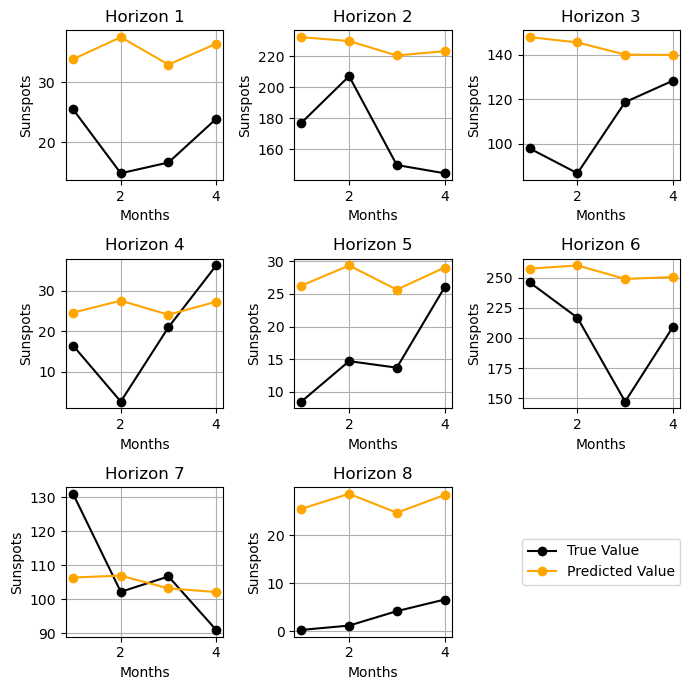

In [6]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(7, 7))  # Adjusted figure size for better spacing
axs = axs.flatten()
for i in range(8):  # Only plot the first 8 graphs
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='orange', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Months')
    ax.set_ylabel('Sunspots')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=[axs[0].lines[0], axs[0].lines[1]], loc='center')  # Center the legend

# Adjust layout
plt.tight_layout()
plt.show()

In [7]:
## Sunspot BD-LSTM Quantile Version
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 30    # default: 30 (change to lower value for less intensive runs)


rmse, mae, mape = [], [], []
rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = [], [], [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [8]:
for exp in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

    # Hyperparameters
    input = 1  # Univariate time series, hence input_size is 1
    hidden_size = [64, 32]
    num_layers = 2
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    num_quantiles = len(quantiles)  # Number of quantiles to predict
    
    # Create the model
    model = BDLSTM_Quantile(input, hidden_size, num_layers, num_quantiles, output_size)

    # Loss and optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # Training loop
    num_epochs = 100 # default: 100 
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
            
            inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
            targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
            
            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
            loss = quantile_loss(outputs, targets, quantiles)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
        
        # Print epoch information for the first epoch and every 10th epoch thereafter
        # if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

    predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
    predicted_values = predicted_values.numpy()
    actuals = actual_values.numpy()[:, :, 0]

    pred_005 = predicted_values[:, :, 0]
    pred_025 = predicted_values[:, :, 1]
    pred_050 = predicted_values[:, :, 2]
    pred_075 = predicted_values[:, :, 3]
    pred_095 = predicted_values[:, :, 4]
    
    ## Calculate RMSE here
    mse_005 = mean_squared_error(pred_005, actuals)
    mse_025 = mean_squared_error(pred_025, actuals)
    mse_050 = mean_squared_error(pred_050, actuals)
    mse_075 = mean_squared_error(pred_075, actuals)
    mse_095 = mean_squared_error(pred_095, actuals)

    rmse_005.append(np.sqrt(mse_005))
    rmse_025.append(np.sqrt(mse_025))
    rmse_050.append(np.sqrt(mse_050))
    rmse_075.append(np.sqrt(mse_075))
    rmse_095.append(np.sqrt(mse_095))

    pred_values = predicted_values.reshape(-1, 1)
    pred_values = scaler.inverse_transform(pred_values)
    pred_values = pred_values.reshape(predicted_values.shape)
    actual_values = scaler.inverse_transform(actuals)
    
    predicted_005 = pred_values[:, :, 0]
    predicted_025 = pred_values[:, :, 1]
    predicted_050 = pred_values[:, :, 2]
    predicted_075 = pred_values[:, :, 3]
    predicted_095 = pred_values[:, :, 4]

    mae.append(mean_absolute_error(actual_values, predicted_050))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_050))

    for step in range(output_size):
        mse_step = mean_squared_error(pred_050[: , step], actuals[:, step])
        rmse_steps[step].append(np.sqrt(mse_step))
        mae_steps[step].append(mean_absolute_error(predicted_050[: , step], actual_values[:, step]))
        mape_steps[step].append(mean_absolute_percentage_error(predicted_050[: , step], actual_values[:, step]))
        
    print(f"Experiment {exp+1}/{num_experiments} done")
    
    seed += 1

print(f'Sunspots BD-LSTM Average RMSE across {output_size} time steps at different quantiles:')
print(f'Quantile 0.05: {np.mean(rmse_005):.6f} {pm} {np.std(rmse_005):.6f}')
print(f'Quantile 0.25: {np.mean(rmse_025):.6f} {pm} {np.std(rmse_025):.6f}')
print(f'Quantile 0.50: {np.mean(rmse_050):.6f} {pm} {np.std(rmse_050):.6f}')
print(f'Quantile 0.75: {np.mean(rmse_075):.6f} {pm} {np.std(rmse_075):.6f}')
print(f'Quantile 0.95: {np.mean(rmse_095):.6f} {pm} {np.std(rmse_095):.6f}')

print("--------------------------------------------")

print(f"BD-LSTM Quantile Regression Average Performance: RMSE: {np.mean(rmse_050):.4f} {pm} {np.std(rmse_050):.4f}, MAE: {np.mean(mae):.4f} {pm} {np.std(mae):.4f}, MAPE: {np.mean(mape)*100:.4f}% {pm} {np.std(mape)*100:.4f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, predictions have RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, MAE: {np.mean(mae_steps[step]):.4f} {pm} {np.std(mae_steps[step]):.4f} and MAPE: {np.mean(mape_steps[step])*100:.4f}% {pm} {np.std(mape_steps[step])*100:.4f}%")



Experiment 1/3 done
Experiment 2/3 done
Experiment 3/3 done
BD-LSTM Average RMSE across 4 time steps at different quantiles:
Quantile 0.05: 0.137110 ± 0.007037
Quantile 0.25: 0.095114 ± 0.005935
Quantile 0.50: 0.082125 ± 0.003185
Quantile 0.75: 0.099658 ± 0.005206
Quantile 0.95: 0.190410 ± 0.006901
--------------------------------------------
Univariate Quantile Regression Average Performance: RMSE: 0.0821 ± 0.0032, MAE: 23.3657 ± 0.7334, MAPE: 111313955900620800.0000% ± 8213864906752000.0000%
At time step 1, predictions have RMSE: 0.0754 ± 0.0015, MAE: 21.4271 ± 0.5740 and MAPE: 37.8124% ± 3.1018%
At time step 2, predictions have RMSE: 0.0808 ± 0.0037, MAE: 23.1628 ± 0.6905 and MAPE: 39.5836% ± 2.3907%
At time step 3, predictions have RMSE: 0.0844 ± 0.0025, MAE: 23.8565 ± 0.6321 and MAPE: 43.1977% ± 2.7615%
At time step 4, predictions have RMSE: 0.0873 ± 0.0052, MAE: 25.0161 ± 1.2853 and MAPE: 52.2553% ± 11.4816%


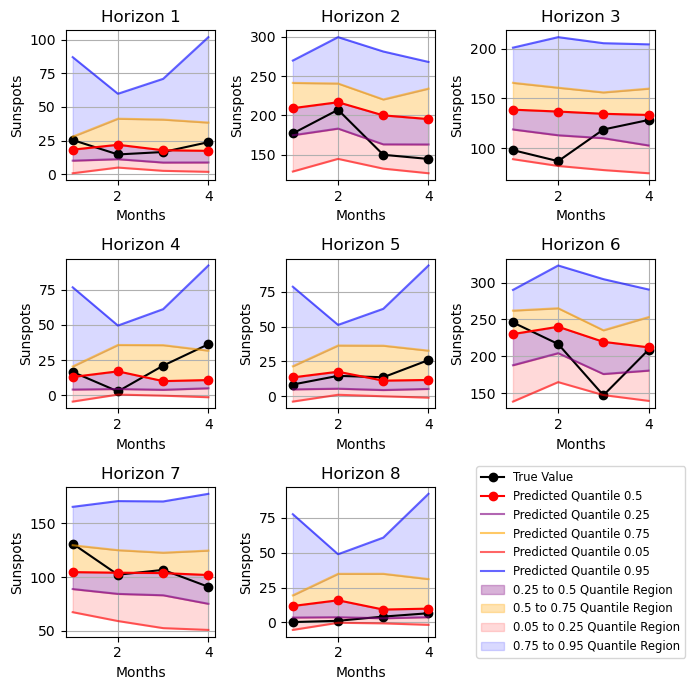

In [9]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], marker='o', linestyle='-', color='red', label='Predicted Quantile 0.5')
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Months')
    ax.set_ylabel('Sunspots')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()
plt.show()

In [10]:
## 2. Mackey-Glass
data = mackey_glass(n_timesteps = 3000, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1.0, seed=5925)
data = data.flatten()
data = pd.Series(data, name='Response')
data.index = range(len(data)) 

scaler = MinMaxScaler(feature_range=(0, 1))
response_reshaped = np.array(data).reshape(-1, 1)
response_scaled = scaler.fit_transform(response_reshaped).flatten()

## Usage: define our parameters
input_size = 10        # 10 steps input (showcase our model can handle different input/output sizes)
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925
num_experiments = 30   # default: 30

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [11]:
for exp in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 
    # Hyperparameters
    input = 1  # Univariate time series
    hidden_sizes = [64, 32]
    num_layers = len(hidden_sizes)
    model = BDLSTM(input, hidden_sizes, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # related work (MSE & ADAM = 0.001)
    
    # Training loop
    num_epochs = 100 # default: 100 (lower this number for quicker runtime)
    for epoch in range(1, num_epochs + 1):
        model.train()
        for inputs, targets in train_dataloader:
            inputs = inputs.unsqueeze(-1)  # Add feature dimension
            targets = targets
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # if epoch == 1 or epoch % 10 == 0:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

    # Evaluate the model on the test set
    model.eval()
    y_pred = []
    y_test = []
    
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs = inputs.unsqueeze(-1)
            targets = targets
            outputs = model(inputs)
            y_pred.append(outputs.numpy())
            y_test.append(targets.numpy())
    
    # Convert lists to numpy arrays
    y_pred = np.concatenate(y_pred, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(y_pred[step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Experiment {exp+1}/{num_experiments} done")
    seed += 1

print(f"Mackey-Glass BD-LSTM Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )

Experiment 1/3 done
Experiment 2/3 done
Experiment 3/3 done
Sunspots BD-LSTM Regression: After 3 experimental runs, here are the results:
Across 6 predictive time steps, Avg RMSE: 0.1728 ± 0.0083, Avg MAE: 0.14 ± 0.01, Avg MAPE: 16.962% ± 1.043%
At time step 1, Avg RMSE: 0.1393 ± 0.0704, Avg MAE: 0.09 ± 0.01, Avg MAPE: 11.033% ± 1.080%
At time step 2, Avg RMSE: 0.1942 ± 0.0525, Avg MAE: 0.12 ± 0.01, Avg MAPE: 14.343% ± 1.195%
At time step 3, Avg RMSE: 0.1275 ± 0.0853, Avg MAE: 0.13 ± 0.01, Avg MAPE: 16.081% ± 1.326%
At time step 4, Avg RMSE: 0.1249 ± 0.0710, Avg MAE: 0.15 ± 0.01, Avg MAPE: 18.270% ± 0.977%
At time step 5, Avg RMSE: 0.1758 ± 0.0534, Avg MAE: 0.16 ± 0.01, Avg MAPE: 20.005% ± 1.304%
At time step 6, Avg RMSE: 0.0533 ± 0.0291, Avg MAE: 0.18 ± 0.01, Avg MAPE: 22.039% ± 0.823%


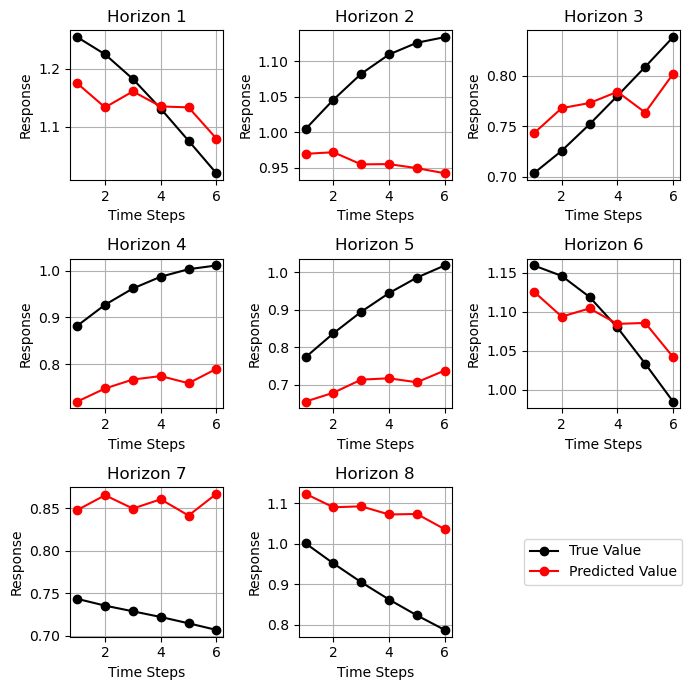

In [12]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(7, 7))  # Adjusted figure size for better spacing
axs = axs.flatten()
for i in range(8):  # Only plot the first 8 graphs
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=[axs[0].lines[0], axs[0].lines[1]], loc='center')  # Center the legend

# Adjust layout
plt.tight_layout()
plt.show()

In [13]:
# Mackey-Glass BD-LSTM Quantile Version
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 30    # default: 30 (change to lower value for less intensive runs)


rmse, mae, mape = [], [], []
rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = [], [], [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [14]:
for exp in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

    # Hyperparameters
    input = 1  # Univariate time series, hence input_size is 1
    hidden_size = [64, 32]
    num_layers = 2
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    num_quantiles = len(quantiles)  # Number of quantiles to predict
    
    # Create the model
    model = BDLSTM_Quantile(input, hidden_size, num_layers, num_quantiles, output_size)

    # Loss and optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # Training loop
    num_epochs = 100 # default: 100 
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
            
            inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
            targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
            
            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
            loss = quantile_loss(outputs, targets, quantiles)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
        
        # Print epoch information for the first epoch and every 10th epoch thereafter
        # if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

    predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
    predicted_values = predicted_values.numpy()
    actuals = actual_values.numpy()[:, :, 0]

    pred_005 = predicted_values[:, :, 0]
    pred_025 = predicted_values[:, :, 1]
    pred_050 = predicted_values[:, :, 2]
    pred_075 = predicted_values[:, :, 3]
    pred_095 = predicted_values[:, :, 4]
    
    ## Calculate RMSE here
    mse_005 = mean_squared_error(pred_005, actuals)
    mse_025 = mean_squared_error(pred_025, actuals)
    mse_050 = mean_squared_error(pred_050, actuals)
    mse_075 = mean_squared_error(pred_075, actuals)
    mse_095 = mean_squared_error(pred_095, actuals)

    rmse_005.append(np.sqrt(mse_005))
    rmse_025.append(np.sqrt(mse_025))
    rmse_050.append(np.sqrt(mse_050))
    rmse_075.append(np.sqrt(mse_075))
    rmse_095.append(np.sqrt(mse_095))

    pred_values = predicted_values.reshape(-1, 1)
    pred_values = scaler.inverse_transform(pred_values)
    pred_values = pred_values.reshape(predicted_values.shape)
    actual_values = scaler.inverse_transform(actuals)
    
    predicted_005 = pred_values[:, :, 0]
    predicted_025 = pred_values[:, :, 1]
    predicted_050 = pred_values[:, :, 2]
    predicted_075 = pred_values[:, :, 3]
    predicted_095 = pred_values[:, :, 4]

    mae.append(mean_absolute_error(actual_values, predicted_050))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_050))

    for step in range(output_size):
        mse_step = mean_squared_error(pred_050[: , step], actuals[:, step])
        rmse_steps[step].append(np.sqrt(mse_step))
        mae_steps[step].append(mean_absolute_error(predicted_050[: , step], actual_values[:, step]))
        mape_steps[step].append(mean_absolute_percentage_error(predicted_050[: , step], actual_values[:, step]))
        
    print(f"Experiment {exp+1}/{num_experiments} done")
    
    seed += 1

print(f'Mackey-Glass BD-LSTM Average RMSE across {output_size} time steps at different quantiles:')
print(f'Quantile 0.05: {np.mean(rmse_005):.6f} {pm} {np.std(rmse_005):.6f}')
print(f'Quantile 0.25: {np.mean(rmse_025):.6f} {pm} {np.std(rmse_025):.6f}')
print(f'Quantile 0.50: {np.mean(rmse_050):.6f} {pm} {np.std(rmse_050):.6f}')
print(f'Quantile 0.75: {np.mean(rmse_075):.6f} {pm} {np.std(rmse_075):.6f}')
print(f'Quantile 0.95: {np.mean(rmse_095):.6f} {pm} {np.std(rmse_095):.6f}')

print("--------------------------------------------")

print(f"Quantile Regression Average Performance: RMSE: {np.mean(rmse_050):.4f} {pm} {np.std(rmse_050):.4f}, MAE: {np.mean(mae):.4f} {pm} {np.std(mae):.4f}, MAPE: {np.mean(mape)*100:.4f}% {pm} {np.std(mape)*100:.4f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, predictions have RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, MAE: {np.mean(mae_steps[step]):.4f} {pm} {np.std(mae_steps[step]):.4f} and MAPE: {np.mean(mape_steps[step])*100:.4f}% {pm} {np.std(mape_steps[step])*100:.4f}%")



Experiment 1/3 done
Experiment 2/3 done
Experiment 3/3 done
BD-LSTM Average RMSE across 6 time steps at different quantiles:
Quantile 0.05: 0.436919 ± 0.016413
Quantile 0.25: 0.262112 ± 0.003258
Quantile 0.50: 0.188495 ± 0.007856
Quantile 0.75: 0.251476 ± 0.015027
Quantile 0.95: 0.314222 ± 0.006954
--------------------------------------------
Univariate Quantile Regression Average Performance: RMSE: 0.1885 ± 0.0079, MAE: 0.1426 ± 0.0035, MAPE: 18.8629% ± 0.7603%
At time step 1, predictions have RMSE: 0.1257 ± 0.0070, MAE: 0.0991 ± 0.0045 and MAPE: 11.3298% ± 0.2973%
At time step 2, predictions have RMSE: 0.1579 ± 0.0217, MAE: 0.1225 ± 0.0116 and MAPE: 13.6140% ± 0.6894%
At time step 3, predictions have RMSE: 0.1715 ± 0.0166, MAE: 0.1335 ± 0.0092 and MAPE: 14.9557% ± 0.3103%
At time step 4, predictions have RMSE: 0.1907 ± 0.0089, MAE: 0.1490 ± 0.0038 and MAPE: 16.2787% ± 0.4895%
At time step 5, predictions have RMSE: 0.2206 ± 0.0050, MAE: 0.1684 ± 0.0019 and MAPE: 17.5796% ± 0.3875%
At 

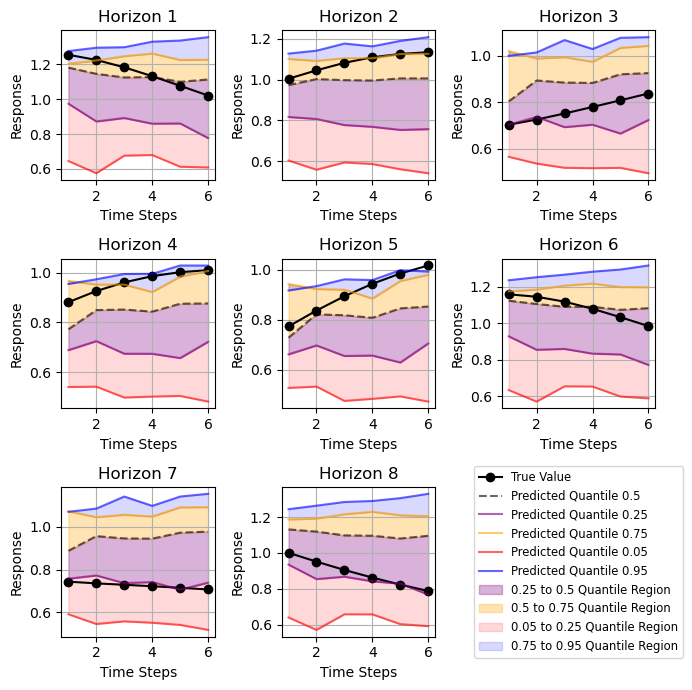

In [47]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha = 0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()
plt.show()

In [49]:
## 3. Lorenz
def lorenz(xyz, *, s=10, r=28, b=2.667):
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# break it down to 3 univariate time series
x_dimension = xyzs[:, 0]
y_dimension = xyzs[:, 1]
z_dimension = xyzs[:, 2]

x_dimension = x_dimension.flatten()
x_dimension = pd.Series(x_dimension, name='Value')
y_dimension = y_dimension.flatten()
y_dimension = pd.Series(y_dimension, name='Value')
z_dimension = z_dimension.flatten()
z_dimension = pd.Series(z_dimension, name='Value')

x_dimension.index = range(len(x_dimension))
y_dimension.index = range(len(y_dimension))
z_dimension.index = range(len(z_dimension))
# print(x_dimension), print(y_dimension), print(z_dimension)

scaler = MinMaxScaler(feature_range=(0, 1))
x_reshaped = np.array(x_dimension).reshape(-1, 1)
y_reshaped = np.array(y_dimension).reshape(-1, 1)
z_reshaped = np.array(z_dimension).reshape(-1, 1)
x_scaled = scaler.fit_transform(x_reshaped).flatten()
y_scaled = scaler.fit_transform(y_reshaped).flatten()
z_scaled = scaler.fit_transform(z_reshaped).flatten()

In [55]:
input_size = 12        
output_size = 8        
train_ratio = 0.8
seed = 5925
num_experiments = 30

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [57]:
## X-Dimension
for exp in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(x_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 
    # Hyperparameters
    input = 1  # Univariate time series
    hidden_sizes = [64, 32]
    num_layers = len(hidden_sizes)
    model = BDLSTM(input, hidden_sizes, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # related work (MSE & ADAM = 0.001)
    
    # Training loop
    num_epochs = 100 # default: 100 (lower this number for quicker runtime)
    for epoch in range(1, num_epochs + 1):
        model.train()
        for inputs, targets in train_dataloader:
            inputs = inputs.unsqueeze(-1)  # Add feature dimension
            targets = targets
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # if epoch == 1 or epoch % 10 == 0:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

    # Evaluate the model on the test set
    model.eval()
    y_pred = []
    y_test = []
    
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs = inputs.unsqueeze(-1)
            targets = targets
            outputs = model(inputs)
            y_pred.append(outputs.numpy())
            y_test.append(targets.numpy())
    
    # Convert lists to numpy arrays
    y_pred = np.concatenate(y_pred, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(y_pred[step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Experiment {exp+1}/{num_experiments} done")
    seed += 1

print(f"Lorenz X BD-LSTM Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )

Experiment 1/3 done
Experiment 2/3 done
Experiment 3/3 done
Mackey-Glass BD-LSTM Regression: After 3 experimental runs, here are the results:
Across 8 predictive time steps, Avg RMSE: 0.0483 ± 0.0062, Avg MAE: 1.78 ± 0.25, Avg MAPE: 11.442% ± 1.615%
At time step 1, Avg RMSE: 0.0187 ± 0.0074, Avg MAE: 0.99 ± 0.18, Avg MAPE: 6.602% ± 1.385%
At time step 2, Avg RMSE: 0.0489 ± 0.0449, Avg MAE: 1.17 ± 0.17, Avg MAPE: 7.566% ± 1.285%
At time step 3, Avg RMSE: 0.0677 ± 0.0419, Avg MAE: 1.31 ± 0.13, Avg MAPE: 8.596% ± 0.964%
At time step 4, Avg RMSE: 0.0376 ± 0.0211, Avg MAE: 1.63 ± 0.27, Avg MAPE: 10.510% ± 1.684%
At time step 5, Avg RMSE: 0.0388 ± 0.0075, Avg MAE: 1.78 ± 0.31, Avg MAPE: 11.251% ± 1.656%
At time step 6, Avg RMSE: 0.0639 ± 0.0532, Avg MAE: 2.13 ± 0.36, Avg MAPE: 13.645% ± 1.747%
At time step 7, Avg RMSE: 0.0113 ± 0.0051, Avg MAE: 2.38 ± 0.27, Avg MAPE: 15.374% ± 2.130%
At time step 8, Avg RMSE: 0.0257 ± 0.0129, Avg MAE: 2.88 ± 0.38, Avg MAPE: 17.994% ± 2.280%


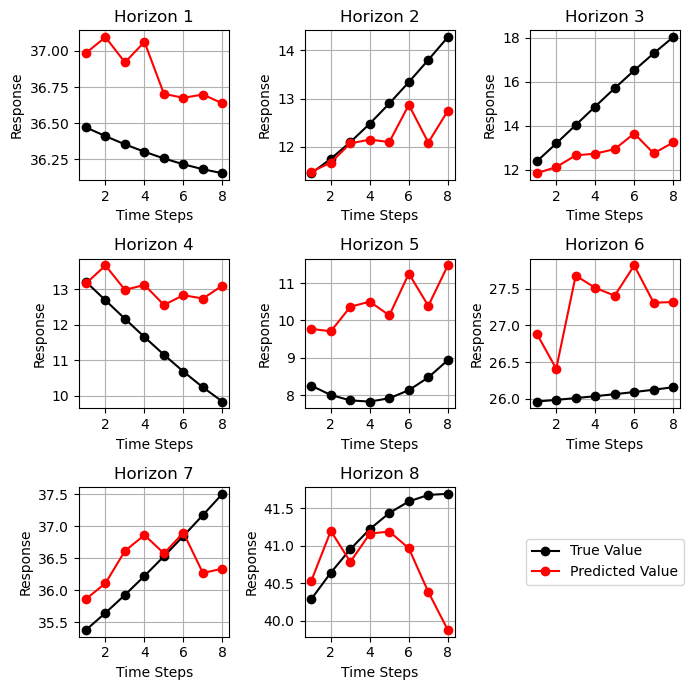

In [58]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(7, 7))  # Adjusted figure size for better spacing
axs = axs.flatten()
for i in range(8):  # Only plot the first 8 graphs
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'X-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=[axs[0].lines[0], axs[0].lines[1]], loc='center')  # Center the legend

# Adjust layout
plt.tight_layout()
plt.show()

In [61]:
## quantile ver
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 30    # default: 30 (change to lower value for less intensive runs)


rmse, mae, mape = [], [], []
rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = [], [], [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [63]:
for exp in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(x_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

    # Hyperparameters
    input = 1  # Univariate time series, hence input_size is 1
    hidden_size = [64, 32]
    num_layers = 2
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    num_quantiles = len(quantiles)  # Number of quantiles to predict
    
    # Create the model
    model = BDLSTM_Quantile(input, hidden_size, num_layers, num_quantiles, output_size)

    # Loss and optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # Training loop
    num_epochs = 100 # default: 100 
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
            
            inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
            targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
            
            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
            loss = quantile_loss(outputs, targets, quantiles)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
        
        # Print epoch information for the first epoch and every 10th epoch thereafter
        # if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

    predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
    predicted_values = predicted_values.numpy()
    actuals = actual_values.numpy()[:, :, 0]

    pred_005 = predicted_values[:, :, 0]
    pred_025 = predicted_values[:, :, 1]
    pred_050 = predicted_values[:, :, 2]
    pred_075 = predicted_values[:, :, 3]
    pred_095 = predicted_values[:, :, 4]
    
    ## Calculate RMSE here
    mse_005 = mean_squared_error(pred_005, actuals)
    mse_025 = mean_squared_error(pred_025, actuals)
    mse_050 = mean_squared_error(pred_050, actuals)
    mse_075 = mean_squared_error(pred_075, actuals)
    mse_095 = mean_squared_error(pred_095, actuals)

    rmse_005.append(np.sqrt(mse_005))
    rmse_025.append(np.sqrt(mse_025))
    rmse_050.append(np.sqrt(mse_050))
    rmse_075.append(np.sqrt(mse_075))
    rmse_095.append(np.sqrt(mse_095))

    pred_values = predicted_values.reshape(-1, 1)
    pred_values = scaler.inverse_transform(pred_values)
    pred_values = pred_values.reshape(predicted_values.shape)
    actual_values = scaler.inverse_transform(actuals)
    
    predicted_005 = pred_values[:, :, 0]
    predicted_025 = pred_values[:, :, 1]
    predicted_050 = pred_values[:, :, 2]
    predicted_075 = pred_values[:, :, 3]
    predicted_095 = pred_values[:, :, 4]

    mae.append(mean_absolute_error(actual_values, predicted_050))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_050))

    for step in range(output_size):
        mse_step = mean_squared_error(pred_050[: , step], actuals[:, step])
        rmse_steps[step].append(np.sqrt(mse_step))
        mae_steps[step].append(mean_absolute_error(predicted_050[: , step], actual_values[:, step]))
        mape_steps[step].append(mean_absolute_percentage_error(predicted_050[: , step], actual_values[:, step]))
        
    print(f"Experiment {exp+1}/{num_experiments} done")
    
    seed += 1

print(f'Lorenz X BD-LSTM Average RMSE across {output_size} time steps at different quantiles:')
print(f'Quantile 0.05: {np.mean(rmse_005):.6f} {pm} {np.std(rmse_005):.6f}')
print(f'Quantile 0.25: {np.mean(rmse_025):.6f} {pm} {np.std(rmse_025):.6f}')
print(f'Quantile 0.50: {np.mean(rmse_050):.6f} {pm} {np.std(rmse_050):.6f}')
print(f'Quantile 0.75: {np.mean(rmse_075):.6f} {pm} {np.std(rmse_075):.6f}')
print(f'Quantile 0.95: {np.mean(rmse_095):.6f} {pm} {np.std(rmse_095):.6f}')

print("--------------------------------------------")

print(f"Quantile Regression Average Performance: RMSE: {np.mean(rmse_050):.4f} {pm} {np.std(rmse_050):.4f}, MAE: {np.mean(mae):.4f} {pm} {np.std(mae):.4f}, MAPE: {np.mean(mape)*100:.4f}% {pm} {np.std(mape)*100:.4f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, predictions have RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, MAE: {np.mean(mae_steps[step]):.4f} {pm} {np.std(mae_steps[step]):.4f} and MAPE: {np.mean(mape_steps[step])*100:.4f}% {pm} {np.std(mape_steps[step])*100:.4f}%")



Experiment 1/3 done
Experiment 2/3 done
Experiment 3/3 done
Mackey-Glass BD-LSTM Average RMSE across 8 time steps at different quantiles:
Quantile 0.05: 0.076680 ± 0.003091
Quantile 0.25: 0.038285 ± 0.002556
Quantile 0.50: 0.034161 ± 0.003403
Quantile 0.75: 0.040810 ± 0.007287
Quantile 0.95: 0.084700 ± 0.007951
--------------------------------------------
Quantile Regression Average Performance: RMSE: 0.0342 ± 0.0034, MAE: 1.1884 ± 0.1564, MAPE: 7.8533% ± 1.2536%
At time step 1, predictions have RMSE: 0.0189 ± 0.0046, MAE: 0.6979 ± 0.1759 and MAPE: 3.8279% ± 0.9761%
At time step 2, predictions have RMSE: 0.0208 ± 0.0012, MAE: 0.7734 ± 0.0950 and MAPE: 4.2741% ± 0.3643%
At time step 3, predictions have RMSE: 0.0246 ± 0.0030, MAE: 0.9177 ± 0.1358 and MAPE: 4.8817% ± 0.6781%
At time step 4, predictions have RMSE: 0.0302 ± 0.0041, MAE: 1.0747 ± 0.1547 and MAPE: 5.8255% ± 0.9798%
At time step 5, predictions have RMSE: 0.0306 ± 0.0028, MAE: 1.1292 ± 0.1376 and MAPE: 5.8862% ± 0.5483%
At time

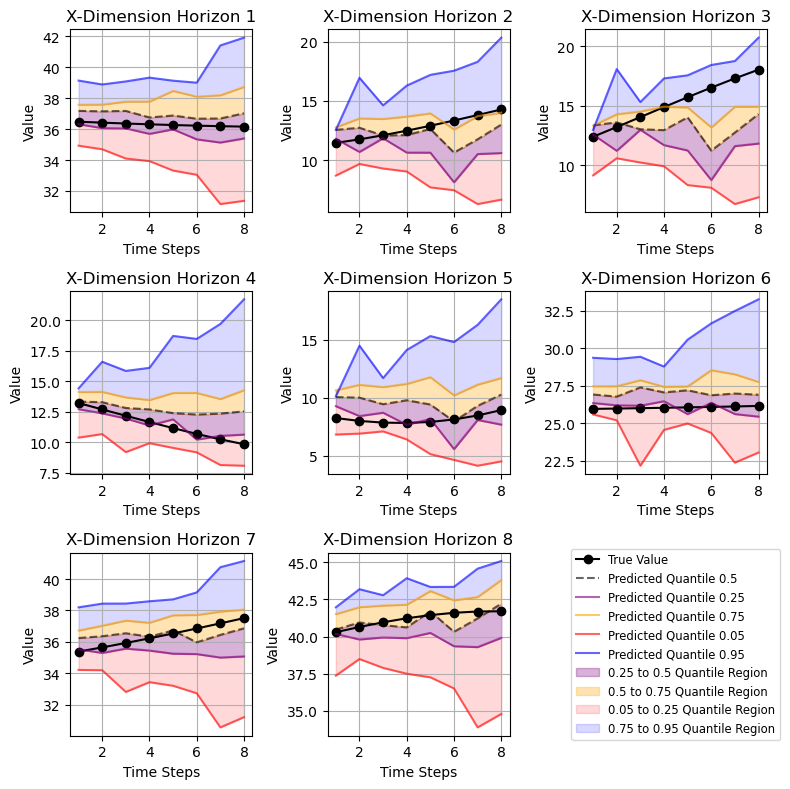

In [67]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha = 0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'X-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()
plt.show()

In [69]:
input_size = 12        
output_size = 8        
train_ratio = 0.8
seed = 5925
num_experiments = 30

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

## Y-Dimension
for exp in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(y_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 
    # Hyperparameters
    input = 1  # Univariate time series
    hidden_sizes = [64, 32]
    num_layers = len(hidden_sizes)
    model = BDLSTM(input, hidden_sizes, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # related work (MSE & ADAM = 0.001)
    
    # Training loop
    num_epochs = 100 # default: 100 (lower this number for quicker runtime)
    for epoch in range(1, num_epochs + 1):
        model.train()
        for inputs, targets in train_dataloader:
            inputs = inputs.unsqueeze(-1)  # Add feature dimension
            targets = targets
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # if epoch == 1 or epoch % 10 == 0:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

    # Evaluate the model on the test set
    model.eval()
    y_pred = []
    y_test = []
    
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs = inputs.unsqueeze(-1)
            targets = targets
            outputs = model(inputs)
            y_pred.append(outputs.numpy())
            y_test.append(targets.numpy())
    
    # Convert lists to numpy arrays
    y_pred = np.concatenate(y_pred, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(y_pred[step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Experiment {exp+1}/{num_experiments} done")
    seed += 1

print(f"Lorenz Y BD-LSTM Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )

Experiment 1/3 done
Experiment 2/3 done
Experiment 3/3 done
Lorenz Y BD-LSTM Regression: After 3 experimental runs, here are the results:
Across 8 predictive time steps, Avg RMSE: 0.0620 ± 0.0042, Avg MAE: 2.09 ± 0.16, Avg MAPE: 12.585% ± 1.187%
At time step 1, Avg RMSE: 0.0359 ± 0.0354, Avg MAE: 1.12 ± 0.13, Avg MAPE: 7.537% ± 1.048%
At time step 2, Avg RMSE: 0.0282 ± 0.0218, Avg MAE: 1.36 ± 0.11, Avg MAPE: 8.579% ± 0.743%
At time step 3, Avg RMSE: 0.0590 ± 0.0311, Avg MAE: 1.60 ± 0.17, Avg MAPE: 10.200% ± 1.178%
At time step 4, Avg RMSE: 0.0531 ± 0.0324, Avg MAE: 1.97 ± 0.17, Avg MAPE: 11.750% ± 1.188%
At time step 5, Avg RMSE: 0.0544 ± 0.0150, Avg MAE: 2.18 ± 0.21, Avg MAPE: 13.041% ± 1.508%
At time step 6, Avg RMSE: 0.0143 ± 0.0063, Avg MAE: 2.55 ± 0.21, Avg MAPE: 14.738% ± 1.608%
At time step 7, Avg RMSE: 0.0208 ± 0.0109, Avg MAE: 2.85 ± 0.12, Avg MAPE: 16.800% ± 1.456%
At time step 8, Avg RMSE: 0.0295 ± 0.0158, Avg MAE: 3.11 ± 0.15, Avg MAPE: 18.037% ± 1.153%


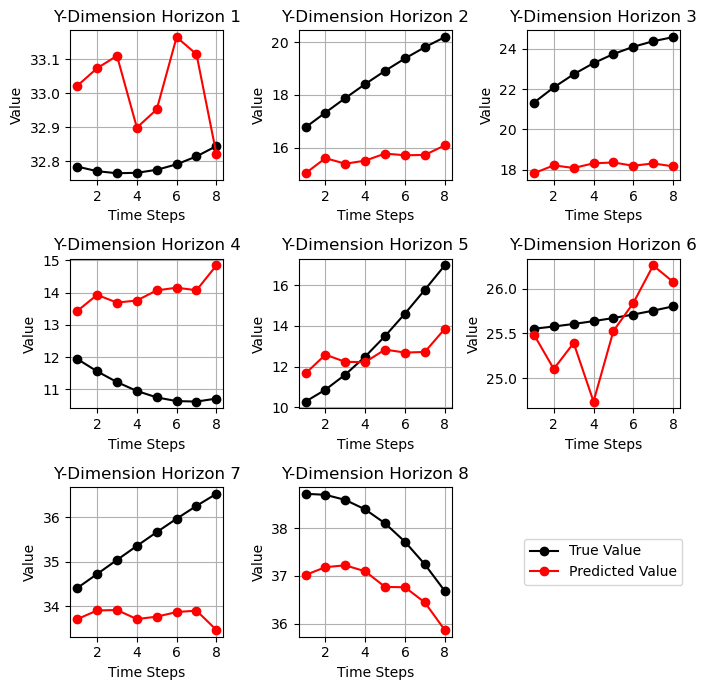

In [70]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(7, 7))  # Adjusted figure size for better spacing
axs = axs.flatten()
for i in range(8):  # Only plot the first 8 graphs
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Y-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=[axs[0].lines[0], axs[0].lines[1]], loc='center')  # Center the legend

# Adjust layout
plt.tight_layout()
plt.show()

In [73]:
## quantile ver
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 30    # default: 30 (change to lower value for less intensive runs)

rmse, mae, mape = [], [], []
rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = [], [], [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

for exp in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(y_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

    # Hyperparameters
    input = 1  # Univariate time series, hence input_size is 1
    hidden_size = [64, 32]
    num_layers = 2
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    num_quantiles = len(quantiles)  # Number of quantiles to predict
    
    # Create the model
    model = BDLSTM_Quantile(input, hidden_size, num_layers, num_quantiles, output_size)

    # Loss and optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # Training loop
    num_epochs = 100 # default: 100 
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
            
            inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
            targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
            
            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
            loss = quantile_loss(outputs, targets, quantiles)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
        
        # Print epoch information for the first epoch and every 10th epoch thereafter
        # if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

    predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
    predicted_values = predicted_values.numpy()
    actuals = actual_values.numpy()[:, :, 0]

    pred_005 = predicted_values[:, :, 0]
    pred_025 = predicted_values[:, :, 1]
    pred_050 = predicted_values[:, :, 2]
    pred_075 = predicted_values[:, :, 3]
    pred_095 = predicted_values[:, :, 4]
    
    ## Calculate RMSE here
    mse_005 = mean_squared_error(pred_005, actuals)
    mse_025 = mean_squared_error(pred_025, actuals)
    mse_050 = mean_squared_error(pred_050, actuals)
    mse_075 = mean_squared_error(pred_075, actuals)
    mse_095 = mean_squared_error(pred_095, actuals)

    rmse_005.append(np.sqrt(mse_005))
    rmse_025.append(np.sqrt(mse_025))
    rmse_050.append(np.sqrt(mse_050))
    rmse_075.append(np.sqrt(mse_075))
    rmse_095.append(np.sqrt(mse_095))

    pred_values = predicted_values.reshape(-1, 1)
    pred_values = scaler.inverse_transform(pred_values)
    pred_values = pred_values.reshape(predicted_values.shape)
    actual_values = scaler.inverse_transform(actuals)
    
    predicted_005 = pred_values[:, :, 0]
    predicted_025 = pred_values[:, :, 1]
    predicted_050 = pred_values[:, :, 2]
    predicted_075 = pred_values[:, :, 3]
    predicted_095 = pred_values[:, :, 4]

    mae.append(mean_absolute_error(actual_values, predicted_050))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_050))

    for step in range(output_size):
        mse_step = mean_squared_error(pred_050[: , step], actuals[:, step])
        rmse_steps[step].append(np.sqrt(mse_step))
        mae_steps[step].append(mean_absolute_error(predicted_050[: , step], actual_values[:, step]))
        mape_steps[step].append(mean_absolute_percentage_error(predicted_050[: , step], actual_values[:, step]))
        
    print(f"Experiment {exp+1}/{num_experiments} done")
    
    seed += 1

print(f'Lorenz Y BD-LSTM Average RMSE across {output_size} time steps at different quantiles:')
print(f'Quantile 0.05: {np.mean(rmse_005):.6f} {pm} {np.std(rmse_005):.6f}')
print(f'Quantile 0.25: {np.mean(rmse_025):.6f} {pm} {np.std(rmse_025):.6f}')
print(f'Quantile 0.50: {np.mean(rmse_050):.6f} {pm} {np.std(rmse_050):.6f}')
print(f'Quantile 0.75: {np.mean(rmse_075):.6f} {pm} {np.std(rmse_075):.6f}')
print(f'Quantile 0.95: {np.mean(rmse_095):.6f} {pm} {np.std(rmse_095):.6f}')

print("--------------------------------------------")

print(f"Quantile Regression Average Performance: RMSE: {np.mean(rmse_050):.4f} {pm} {np.std(rmse_050):.4f}, MAE: {np.mean(mae):.4f} {pm} {np.std(mae):.4f}, MAPE: {np.mean(mape)*100:.4f}% {pm} {np.std(mape)*100:.4f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, predictions have RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, MAE: {np.mean(mae_steps[step]):.4f} {pm} {np.std(mae_steps[step]):.4f} and MAPE: {np.mean(mape_steps[step])*100:.4f}% {pm} {np.std(mape_steps[step])*100:.4f}%")



Experiment 1/3 done
Experiment 2/3 done
Experiment 3/3 done
Lorenz Y BD-LSTM Average RMSE across 8 time steps at different quantiles:
Quantile 0.05: 0.089662 ± 0.004799
Quantile 0.25: 0.055696 ± 0.005369
Quantile 0.50: 0.049822 ± 0.003375
Quantile 0.75: 0.054425 ± 0.001472
Quantile 0.95: 0.104771 ± 0.009711
--------------------------------------------
Quantile Regression Average Performance: RMSE: 0.0498 ± 0.0034, MAE: 1.6273 ± 0.1485, MAPE: 9.3763% ± 0.7680%
At time step 1, predictions have RMSE: 0.0225 ± 0.0008, MAE: 0.7969 ± 0.0510 and MAPE: 4.2078% ± 0.4131%
At time step 2, predictions have RMSE: 0.0267 ± 0.0013, MAE: 0.9346 ± 0.0874 and MAPE: 5.0608% ± 0.4502%
At time step 3, predictions have RMSE: 0.0328 ± 0.0033, MAE: 1.1595 ± 0.1827 and MAPE: 6.2343% ± 0.9720%
At time step 4, predictions have RMSE: 0.0419 ± 0.0028, MAE: 1.4455 ± 0.0791 and MAPE: 7.5590% ± 0.7840%
At time step 5, predictions have RMSE: 0.0483 ± 0.0037, MAE: 1.6722 ± 0.1727 and MAPE: 8.5267% ± 0.9924%
At time ste

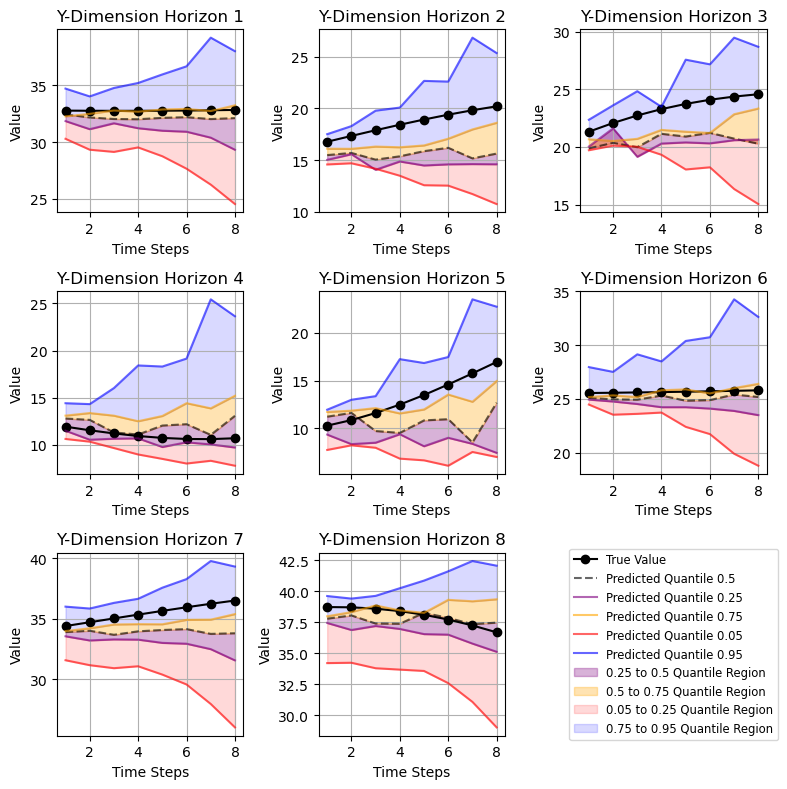

In [74]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha = 0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Y-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()
plt.show()

In [77]:
input_size = 12        
output_size = 8        
train_ratio = 0.8
seed = 5925
num_experiments = 30

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

## Z-Dimension
for exp in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(z_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 
    # Hyperparameters
    input = 1  # Univariate time series
    hidden_sizes = [64, 32]
    num_layers = len(hidden_sizes)
    model = BDLSTM(input, hidden_sizes, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # related work (MSE & ADAM = 0.001)
    
    # Training loop
    num_epochs = 100 # default: 100 (lower this number for quicker runtime)
    for epoch in range(1, num_epochs + 1):
        model.train()
        for inputs, targets in train_dataloader:
            inputs = inputs.unsqueeze(-1)  # Add feature dimension
            targets = targets
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # if epoch == 1 or epoch % 10 == 0:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

    # Evaluate the model on the test set
    model.eval()
    y_pred = []
    y_test = []
    
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs = inputs.unsqueeze(-1)
            targets = targets
            outputs = model(inputs)
            y_pred.append(outputs.numpy())
            y_test.append(targets.numpy())
    
    # Convert lists to numpy arrays
    y_pred = np.concatenate(y_pred, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(y_pred[step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Experiment {exp+1}/{num_experiments} done")
    seed += 1

print(f"Lorenz Z BD-LSTM Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )

Experiment 1/3 done
Experiment 2/3 done
Experiment 3/3 done
Lorenz Z BD-LSTM Regression: After 3 experimental runs, here are the results:
Across 8 predictive time steps, Avg RMSE: 0.0320 ± 0.0037, Avg MAE: 1.14 ± 0.07, Avg MAPE: 5.110% ± 0.426%
At time step 1, Avg RMSE: 0.0170 ± 0.0055, Avg MAE: 0.73 ± 0.27, Avg MAPE: 3.527% ± 1.202%
At time step 2, Avg RMSE: 0.0109 ± 0.0023, Avg MAE: 0.62 ± 0.11, Avg MAPE: 2.965% ± 0.548%
At time step 3, Avg RMSE: 0.0247 ± 0.0086, Avg MAE: 0.58 ± 0.11, Avg MAPE: 2.780% ± 0.379%
At time step 4, Avg RMSE: 0.0311 ± 0.0087, Avg MAE: 0.81 ± 0.11, Avg MAPE: 3.590% ± 0.239%
At time step 5, Avg RMSE: 0.0287 ± 0.0072, Avg MAE: 1.09 ± 0.08, Avg MAPE: 4.791% ± 0.040%
At time step 6, Avg RMSE: 0.0230 ± 0.0125, Avg MAE: 1.54 ± 0.20, Avg MAPE: 6.642% ± 1.096%
At time step 7, Avg RMSE: 0.0144 ± 0.0037, Avg MAE: 1.73 ± 0.22, Avg MAPE: 7.715% ± 1.213%
At time step 8, Avg RMSE: 0.0264 ± 0.0134, Avg MAE: 2.02 ± 0.21, Avg MAPE: 8.870% ± 1.292%


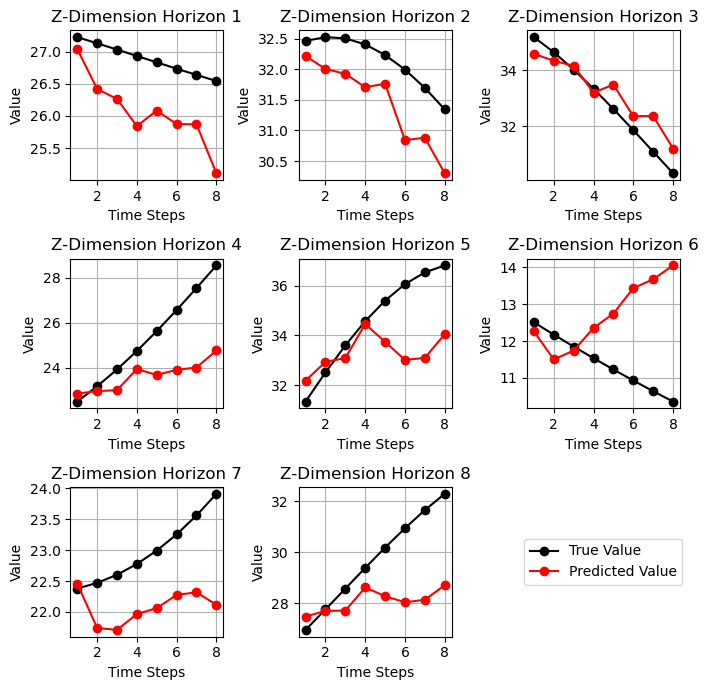

In [78]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(7, 7))  # Adjusted figure size for better spacing
axs = axs.flatten()
for i in range(8):  # Only plot the first 8 graphs
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Z-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=[axs[0].lines[0], axs[0].lines[1]], loc='center')  # Center the legend

# Adjust layout
plt.tight_layout()
plt.show()

In [79]:
## quantile ver
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 30    # default: 30 (change to lower value for less intensive runs)

rmse, mae, mape = [], [], []
rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = [], [], [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

for exp in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(z_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

    # Hyperparameters
    input = 1  # Univariate time series, hence input_size is 1
    hidden_size = [64, 32]
    num_layers = 2
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    num_quantiles = len(quantiles)  # Number of quantiles to predict
    
    # Create the model
    model = BDLSTM_Quantile(input, hidden_size, num_layers, num_quantiles, output_size)

    # Loss and optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # Training loop
    num_epochs = 100 # default: 100 
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
            
            inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
            targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
            
            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
            loss = quantile_loss(outputs, targets, quantiles)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
        
        # Print epoch information for the first epoch and every 10th epoch thereafter
        # if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

    predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
    predicted_values = predicted_values.numpy()
    actuals = actual_values.numpy()[:, :, 0]

    pred_005 = predicted_values[:, :, 0]
    pred_025 = predicted_values[:, :, 1]
    pred_050 = predicted_values[:, :, 2]
    pred_075 = predicted_values[:, :, 3]
    pred_095 = predicted_values[:, :, 4]
    
    ## Calculate RMSE here
    mse_005 = mean_squared_error(pred_005, actuals)
    mse_025 = mean_squared_error(pred_025, actuals)
    mse_050 = mean_squared_error(pred_050, actuals)
    mse_075 = mean_squared_error(pred_075, actuals)
    mse_095 = mean_squared_error(pred_095, actuals)

    rmse_005.append(np.sqrt(mse_005))
    rmse_025.append(np.sqrt(mse_025))
    rmse_050.append(np.sqrt(mse_050))
    rmse_075.append(np.sqrt(mse_075))
    rmse_095.append(np.sqrt(mse_095))

    pred_values = predicted_values.reshape(-1, 1)
    pred_values = scaler.inverse_transform(pred_values)
    pred_values = pred_values.reshape(predicted_values.shape)
    actual_values = scaler.inverse_transform(actuals)
    
    predicted_005 = pred_values[:, :, 0]
    predicted_025 = pred_values[:, :, 1]
    predicted_050 = pred_values[:, :, 2]
    predicted_075 = pred_values[:, :, 3]
    predicted_095 = pred_values[:, :, 4]

    mae.append(mean_absolute_error(actual_values, predicted_050))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_050))

    for step in range(output_size):
        mse_step = mean_squared_error(pred_050[: , step], actuals[:, step])
        rmse_steps[step].append(np.sqrt(mse_step))
        mae_steps[step].append(mean_absolute_error(predicted_050[: , step], actual_values[:, step]))
        mape_steps[step].append(mean_absolute_percentage_error(predicted_050[: , step], actual_values[:, step]))
        
    print(f"Experiment {exp+1}/{num_experiments} done")
    
    seed += 1

print(f'Lorenz Z BD-LSTM Average RMSE across {output_size} time steps at different quantiles:')
print(f'Quantile 0.05: {np.mean(rmse_005):.6f} {pm} {np.std(rmse_005):.6f}')
print(f'Quantile 0.25: {np.mean(rmse_025):.6f} {pm} {np.std(rmse_025):.6f}')
print(f'Quantile 0.50: {np.mean(rmse_050):.6f} {pm} {np.std(rmse_050):.6f}')
print(f'Quantile 0.75: {np.mean(rmse_075):.6f} {pm} {np.std(rmse_075):.6f}')
print(f'Quantile 0.95: {np.mean(rmse_095):.6f} {pm} {np.std(rmse_095):.6f}')

print("--------------------------------------------")

print(f"Quantile Regression Average Performance: RMSE: {np.mean(rmse_050):.4f} {pm} {np.std(rmse_050):.4f}, MAE: {np.mean(mae):.4f} {pm} {np.std(mae):.4f}, MAPE: {np.mean(mape)*100:.4f}% {pm} {np.std(mape)*100:.4f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, predictions have RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, MAE: {np.mean(mae_steps[step]):.4f} {pm} {np.std(mae_steps[step]):.4f} and MAPE: {np.mean(mape_steps[step])*100:.4f}% {pm} {np.std(mape_steps[step])*100:.4f}%")



Experiment 1/3 done
Experiment 2/3 done
Experiment 3/3 done
Lorenz Z BD-LSTM Average RMSE across 8 time steps at different quantiles:
Quantile 0.05: 0.061023 ± 0.002603
Quantile 0.25: 0.034649 ± 0.007456
Quantile 0.50: 0.025785 ± 0.003612
Quantile 0.75: 0.027772 ± 0.004118
Quantile 0.95: 0.078934 ± 0.026732
--------------------------------------------
Quantile Regression Average Performance: RMSE: 0.0258 ± 0.0036, MAE: 0.7967 ± 0.1156, MAPE: 3.6513% ± 0.3049%
At time step 1, predictions have RMSE: 0.0112 ± 0.0033, MAE: 0.3717 ± 0.0771 and MAPE: 1.6846% ± 0.3220%
At time step 2, predictions have RMSE: 0.0126 ± 0.0006, MAE: 0.4093 ± 0.0484 and MAPE: 1.9793% ± 0.1595%
At time step 3, predictions have RMSE: 0.0156 ± 0.0023, MAE: 0.5003 ± 0.0881 and MAPE: 2.5062% ± 0.6069%
At time step 4, predictions have RMSE: 0.0176 ± 0.0004, MAE: 0.5340 ± 0.0558 and MAPE: 2.7302% ± 0.1838%
At time step 5, predictions have RMSE: 0.0212 ± 0.0030, MAE: 0.6641 ± 0.1368 and MAPE: 3.3712% ± 0.5031%
At time ste

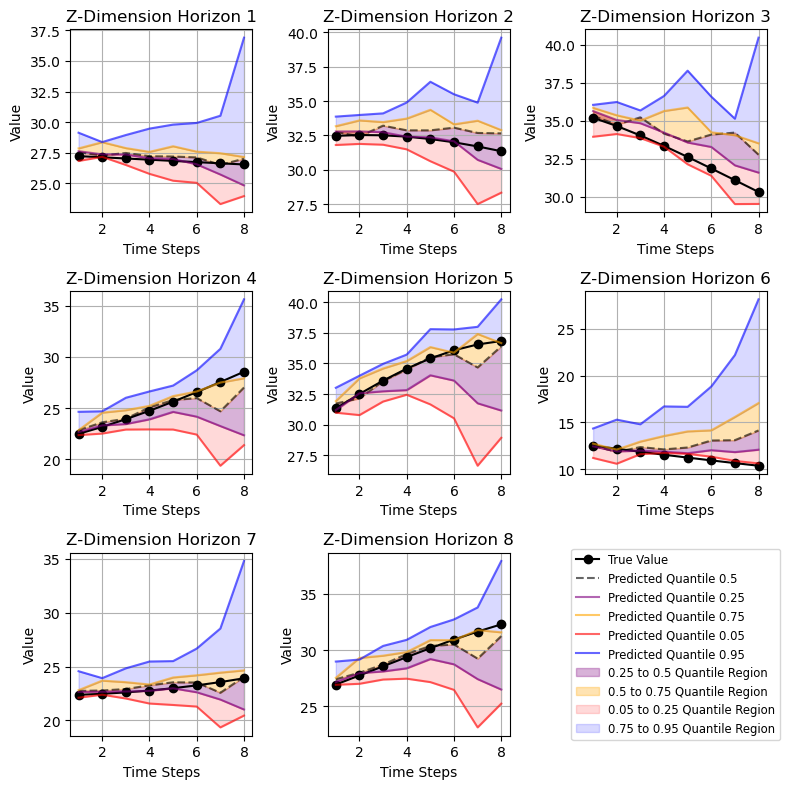

In [81]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha = 0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Z-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()
plt.show()